In [1]:
# Authors: N. Branson, W. Connell, A. Wenteler

In [128]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc
import scipy.stats as stats
import matplotlib.pyplot as plt
from pypalettes import load_cmap
import gzip 
import pickle as pkl 
import os
import mpl_sizes
from collections import defaultdict
import math

formatter = mpl_sizes.get_format("NeurIPS") # options: ICLR, ICML, NeurIPS, InfThesis

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Compare Aggregate deltaAUSPC to Perturbation-level deltaAUSPC

In [152]:
# df_mean_ind = pd.read_csv('individual_results/2-gene/mean.csv')
# df_raw_ind = pd.read_csv('individual_results/2-gene/raw_exp.csv')
# df_uce_ind = pd.read_csv('individual_results/2-gene/uce.csv')
# df_scgpt_ind = pd.read_csv('individual_results/2-gene/scgpt.csv')
# df_gf_ind = pd.read_csv('individual_results/2-gene/gf.csv')
# df_scf_ind = pd.read_csv('individual_results/2-gene/scfoundation.csv')
# df_scbert_ind = pd.read_csv('individual_results/2-gene/scbert.csv')

df_mean_agg = pd.read_csv('aggregated_results/2-gene/mean.csv')
df_raw_agg = pd.read_csv('aggregated_results/2-gene/mlp_baseline.csv')
df_uce_agg = pd.read_csv('aggregated_results/2-gene/uce.csv')
df_scgpt_agg = pd.read_csv('aggregated_results/2-gene/scgpt.csv')
df_gf_agg = pd.read_csv('aggregated_results/2-gene/geneformer.csv')
df_scf_agg = pd.read_csv('aggregated_results/2-gene/scfoundation.csv')
df_scbert_agg = pd.read_csv('aggregated_results/2-gene/scbert.csv')

In [153]:
def add_replicate(df):
    df['replicate'] = df['Tags'].str.extract(r'replicate_(\d+)')
    return df

In [154]:
# df_mean_ind = add_replicate(df_mean_ind)
# df_raw_ind = add_replicate(df_raw_ind)
# df_uce_ind = add_replicate(df_uce_ind)
# df_scgpt_ind = add_replicate(df_scgpt_ind)
# df_gf_ind = add_replicate(df_gf_ind)
# df_scf_ind = add_replicate(df_scf_ind)
# df_scbert_ind = add_replicate(df_scbert_ind)

In [155]:
# df_mean_agg = add_replicate(df_mean_agg)
# df_raw_agg = add_replicate(df_raw_agg)
# df_uce_agg = add_replicate(df_uce_agg)
# df_scgpt_agg = add_replicate(df_scgpt_agg)
# df_gf_agg = add_replicate(df_gf_agg)
# df_scf_agg = add_replicate(df_scf_agg)
# df_scbert_agg = add_replicate(df_scbert_agg)

df_mean_ind = add_replicate(df_mean_ind)
df_raw_ind = add_replicate(df_raw_ind)
df_uce_ind = add_replicate(df_uce_ind)
df_scgpt_ind = add_replicate(df_scgpt_ind)
df_gf_ind = add_replicate(df_gf_ind)
df_scf_ind = add_replicate(df_scf_ind)
df_scbert_ind = add_replicate(df_scbert_ind)

In [156]:
def process_dataframe(df, groupby_cols): 
    df = df.dropna(subset=['test/mse'])
    grouped_df = df.groupby(groupby_cols)['test/mse'].agg(['mean', 'std']).reset_index().dropna()
    grouped_df.rename(columns={'mean': 'mean_test_mse', 'std': 'ste_test_mse'}, inplace=True)
    
    # calculate the standard error of the mean
    grouped_df['ste_test_mse'] = grouped_df['ste_test_mse'] / np.sqrt(3)
    
    grouped_df.drop(columns=[col for col in groupby_cols if col != 'data.split'], inplace=True)
    return grouped_df

In [157]:
df_mean_agg_grouped = process_dataframe(df_mean_agg, ['data.fm', 'data.split'])
df_raw_agg_grouped = process_dataframe(df_raw_agg, ['data.fm', 'data.split'])
df_uce_agg_grouped = process_dataframe(df_uce_agg, ['data.fm', 'data.split'])
df_scgpt_agg_grouped = process_dataframe(df_scgpt_agg, ['data.fm', 'data.split'])
df_gf_agg_grouped = process_dataframe(df_gf_agg, ['data.fm', 'data.split'])
df_scf_agg_grouped = process_dataframe(df_scf_agg, ['data.fm', 'data.split'])
df_scbert_agg_grouped = process_dataframe(df_scbert_agg, ['data.fm', 'data.split'])

df_mean_agg_grouped['model'] = 'mean'
df_raw_agg_grouped['model'] = 'raw'
df_uce_agg_grouped['model'] = 'uce'
df_scgpt_agg_grouped['model'] = 'scgpt'
df_gf_agg_grouped['model'] = 'gf'
df_scf_agg_grouped['model'] = 'scfoundation'
df_scbert_agg_grouped['model'] = 'scbert'

# Concatenate the DataFrames
df_mse_results_agg = pd.concat([
    df_mean_agg_grouped, 
    df_raw_agg_grouped, 
    df_uce_agg_grouped, 
    df_scgpt_agg_grouped, 
    df_gf_agg_grouped, 
    df_scf_agg_grouped, 
    df_scbert_agg_grouped
], axis=0)

df_mse_results_agg.reset_index(drop=True, inplace=True)
df_mse_results_agg

,data.split,mean_test_mse,ste_test_mse,model
0,0.0,0.053372,0.000933,mean
1,0.1,0.052572,0.001020,mean
2,0.2,0.059104,0.002547,mean
3,0.3,0.057222,0.004011,mean
4,0.4,0.066435,0.001669,mean
5,0.5,0.076738,0.009622,mean
6,0.6,0.060708,0.007717,mean
7,0.7,0.052014,0.005936,mean
8,0.0,0.053372,0.000935,raw
9,0.1,0.052608,0.000998,raw


In [158]:
df_mean_ind_grouped = process_dataframe(df_mean_ind, ['data.fm', 'data.split'])
df_raw_ind_grouped = process_dataframe(df_raw_ind, ['data.fm', 'data.split'])
df_uce_ind_grouped = process_dataframe(df_uce_ind, ['data.fm', 'data.split'])
df_scgpt_ind_grouped = process_dataframe(df_scgpt_ind, ['data.fm', 'data.split'])
df_gf_ind_grouped = process_dataframe(df_gf_ind, ['data.fm', 'data.split'])
df_scf_ind_grouped = process_dataframe(df_scf_ind, ['data.fm', 'data.split'])
df_scbert_ind_grouped = process_dataframe(df_scbert_ind, ['data.fm', 'data.split'])

df_mean_ind_grouped['model'] = 'mean'
df_raw_ind_grouped['model'] = 'raw'
df_uce_ind_grouped['model'] = 'uce'
df_scgpt_ind_grouped['model'] = 'scgpt'
df_gf_ind_grouped['model'] = 'gf'
df_scf_ind_grouped['model'] = 'scfoundation'
df_scbert_ind_grouped['model'] = 'scbert'

# Concatenate the DataFrames
df_mse_results_ind = pd.concat([
    df_mean_ind_grouped, 
    df_raw_ind_grouped, 
    df_uce_ind_grouped, 
    df_scgpt_ind_grouped, 
    df_gf_ind_grouped, 
    df_scf_ind_grouped, 
    df_scbert_ind_grouped
], axis=0)

df_mse_results_ind.reset_index(drop=True, inplace=True)
df_mse_results_ind

,data.split,mean_test_mse,ste_test_mse,model
0,0.0,2.524301,1.053985,mean
1,0.1,0.548791,0.055367,mean
2,0.2,0.580336,0.075091,mean
3,0.3,0.614620,0.073541,mean
4,0.4,0.652556,0.037172,mean
5,0.6,0.659147,0.046891,mean
6,0.7,0.496939,0.055733,mean
7,0.0,0.195487,0.120948,raw
8,0.1,0.484176,0.046131,raw
9,0.2,0.538471,0.082053,raw


In [159]:
df_scbert_agg_grouped

,data.split,mean_test_mse,ste_test_mse,model
0,0.0,0.056551,0.000917,scbert
1,0.1,0.055148,0.000670,scbert
2,0.2,0.061591,0.001963,scbert
3,0.3,0.060222,0.004650,scbert
4,0.4,0.067569,0.002809,scbert
5,0.5,0.079994,0.012398,scbert
6,0.6,0.064930,0.007362,scbert
7,0.7,0.071101,0.005793,scbert


In [161]:
df_mean_ind_grouped = process_dataframe(df_mean_ind, ['data.fm', 'data.split'])
df_raw_ind_grouped = process_dataframe(df_raw_ind, ['data.fm', 'data.split'])
df_uce_ind_grouped = process_dataframe(df_uce_ind, ['data.fm', 'data.split'])
df_scgpt_ind_grouped = process_dataframe(df_scgpt_ind, ['data.fm', 'data.split'])
df_gf_ind_grouped = process_dataframe(df_gf_ind, ['data.fm', 'data.split'])
df_scf_ind_grouped = process_dataframe(df_scf_ind, ['data.fm', 'data.split'])
df_scbert_ind_grouped = process_dataframe(df_scbert_ind, ['data.fm', 'data.split'])

df_mean_ind_grouped['model'] = 'mean'
df_raw_ind_grouped['model'] = 'raw'
df_uce_ind_grouped['model'] = 'uce'
df_scgpt_ind_grouped['model'] = 'scgpt'
df_gf_ind_grouped['model'] = 'gf'
df_scf_ind_grouped['model'] = 'scfoundation'
df_scbert_ind_grouped['model'] = 'scbert'

# process aggregate results
# df_mean_agg_grouped = process_dataframe(df_mean_agg, ['data.fm', 'data.split'])
# df_raw_agg_grouped = process_dataframe(df_raw_agg, ['data.fm', 'data.split'])
# df_uce_agg_grouped = process_dataframe(df_uce_agg, ['data.fm', 'data.split'])
# df_scgpt_agg_grouped = process_dataframe(df_scgpt_agg, ['data.fm', 'data.split'])
# df_gf_agg_grouped = process_dataframe(df_gf_agg, ['data.fm', 'data.split'])
# df_scf_agg_grouped = process_dataframe(df_scf_agg, ['data.fm', 'data.split'])
# df_scbert_agg_grouped = process_dataframe(df_scbert_agg, ['data.fm', 'data.split'])

# Concatenate the DataFrames
# df_mse_results = pd.concat([
#     df_mean_ind_grouped, 
#     df_raw_ind_grouped, 
#     df_uce_ind_grouped, 
#     df_scgpt_ind_grouped, 
#     df_gf_ind_grouped, 
#     df_scf_ind_grouped, 
#     df_scbert_ind_grouped
# ], axis=0)

df_mse_results = pd.concat([
    df_mean_agg_grouped,
    df_raw_agg_grouped,
    df_uce_agg_grouped,
    df_scgpt_agg_grouped,
    df_gf_agg_grouped,
    df_scf_agg_grouped,
    df_scbert_agg_grouped
], axis=0)

df_mse_results.reset_index(drop=True, inplace=True)
df_mse_results

,data.split,mean_test_mse,ste_test_mse,model
0,0.0,0.053372,0.000933,mean
1,0.1,0.052572,0.001020,mean
2,0.2,0.059104,0.002547,mean
3,0.3,0.057222,0.004011,mean
4,0.4,0.066435,0.001669,mean
5,0.5,0.076738,0.009622,mean
6,0.6,0.060708,0.007717,mean
7,0.7,0.052014,0.005936,mean
8,0.0,0.053372,0.000935,raw
9,0.1,0.052608,0.000998,raw


In [162]:
df_raw_agg_grouped

,data.split,mean_test_mse,ste_test_mse,model
0,0.0,0.053372,0.000935,raw
1,0.1,0.052608,0.000998,raw
2,0.2,0.059126,0.002548,raw
3,0.3,0.057284,0.004022,raw
4,0.4,0.066354,0.001610,raw
5,0.5,0.076752,0.009533,raw
6,0.6,0.060496,0.007630,raw
7,0.7,0.051983,0.005928,raw


In [163]:
df_gf_ind_grouped

,data.split,mean_test_mse,ste_test_mse,model
0,0.0,0.489241,0.042656,gf
1,0.1,0.526732,0.055254,gf
2,0.2,0.550166,0.068543,gf
3,0.3,0.602739,0.075853,gf
4,0.4,0.660888,0.045227,gf
6,0.6,0.623003,0.053678,gf
7,0.7,0.487252,0.047604,gf


In [164]:

def plot_with_shaded_confidence_intervals(x, mean_y, model_y, error_mean, error_model, model_name):
    """
    Plot line graphs with shaded regions to represent confidence intervals or variance.
    
    :param x: Array-like, values of Sparsification Probability (X-axis)
    :param mean_y: Array-like, Mean model performance (Y-axis)
    :param model_y: Array-like, Baseline model performance (Y-axis)
    :param error_mean: Array-like, Error (standard deviation or confidence interval) for the model
    :param error_model: Array-like, Error (standard deviation or confidence interval) for the baseline
    """
    
    # Plot the mean model performance
    plt.plot(x, mean_y, 'o-', label='Mean baseline', color='tab:blue')
    
    # Fill the area for confidence intervals for the mean
    plt.fill_between(x, mean_y - error_mean, mean_y + error_mean, color='tab:blue', alpha=0.05)
    
    # Plot the baseline model performance
    plt.plot(x, model_y, 'o-', label='Model', color='tab:orange')
    
    # Fill the area for confidence intervals for the baseline
    plt.fill_between(x, model_y - error_model, model_y + error_model, color='tab:orange', alpha=0.05)
    
    # Axis labels and legend
    plt.xlabel('Sparsification Probability')
    plt.ylabel('MSE')
    # plt.yscale('log')
    plt.ylim(0.3, 1.15)
    plt.gca().set_facecolor('white')
    
    plt.gca().spines['bottom'].set_color('black')
    plt.gca().spines['top'].set_color('black')
    plt.gca().spines['right'].set_color('black')
    plt.gca().spines['left'].set_color('black')
    # plot a small legend in the upper left corner
    plt.tight_layout() 
    plt.savefig(f'paper_figs/delta_auspc_{model_name}.pdf')

In [165]:
plt.figure(figsize=(6, 3), dpi=300)
splits = df_mean_agg_grouped['data.split']
splits = [float(s) for s in splits]
mean_y = df_mean_ind_grouped['mean_test_mse']
model_y = df_uce_ind_grouped['mean_test_mse']
error_mean = df_uce_ind_grouped['ste_test_mse']
model_name = 'uce'
plot_with_shaded_confidence_intervals(splits, mean_y, model_y, error_mean, error_model, model_name)

NameError: name 'error_model' is not defined

<Figure size 1800x900 with 0 Axes>

## Compare mean baseline highly variable genes to mean baseline differentially expressed genes 

(5.50107, 2.3576014285714284)


ValueError: x and y must have same first dimension, but have shapes (8,) and (7,)

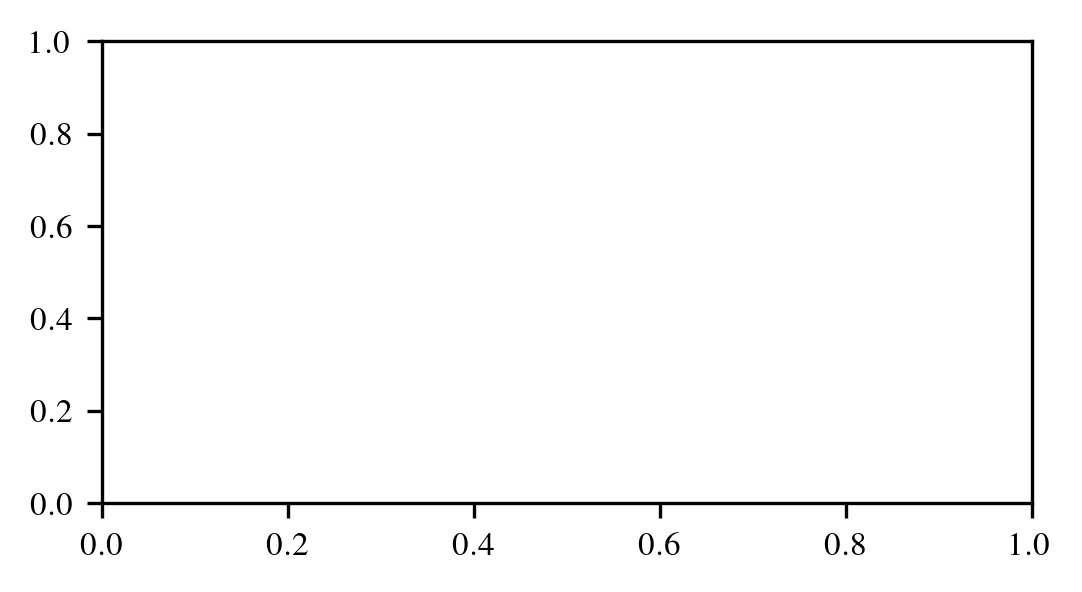

In [166]:
# set dpi = 300 
size = formatter.line_width_plot(aspect_ratio="wide")
print(size)
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)
mean_y = df_mean_ind_grouped['mean_test_mse']
model_y = df_mean_agg_grouped['mean_test_mse']
error_mean = df_mean_ind_grouped['ste_test_mse']
error_model = df_mean_agg_grouped['ste_test_mse']
plot_with_shaded_confidence_intervals(splits, mean_y, model_y, error_mean, error_model, model_name)

In [167]:
df_uce_ind_grouped

,data.split,mean_test_mse,ste_test_mse,model
0,0.0,0.489305,0.042664,uce
1,0.1,0.526861,0.055344,uce
2,0.2,0.550123,0.068556,uce
3,0.3,0.600801,0.071735,uce
4,0.4,0.656268,0.043363,uce
6,0.6,0.623937,0.052679,uce
7,0.7,0.505980,0.047656,uce


In [168]:
# Define a function to run the calculations and store the results for MSE
def collect_mse_results():
    results = {
        'model': [],
        'mean_mse': [],
        'ste_mse': []
    }

    models = {
        'mean': df_mean_ind,
        'scbert': df_scbert_ind,
        'gf': df_gf_ind,
        'scgpt': df_scgpt_ind,
        'scfoundation': df_scf_ind,
        'uce': df_uce_ind,
        'raw': df_raw_ind
    }

    for model_name, df_model in models.items():
        mean_mse = df_model['test/mse'].mean()
        ste_mse = df_model['test/mse'].std() / np.sqrt(len(df_model))
        results['model'].append(model_name)
        results['mean_mse'].append(mean_mse)
        results['ste_mse'].append(ste_mse)

    mean_df = pd.DataFrame({
        'model': results['model'],
        'mean_mse': results['mean_mse']
    })

    ste_df = pd.DataFrame({
        'model': results['model'],
        'ste_mse': results['ste_mse']
    })

    return mean_df, ste_df

# Run the function and collect the results in dataframes
mean_mse_df, ste_mse_df = collect_mse_results()

In [169]:
mean_mse_df

,model,mean_mse
0,mean,1.251696
1,scbert,0.540682
2,gf,0.530640
3,scgpt,0.602972
4,scfoundation,0.535510
5,uce,0.532091
6,raw,0.404806


In [170]:
ste_mse_df

,model,ste_mse
0,mean,0.092180
1,scbert,0.007133
2,gf,0.006722
3,scgpt,0.021785
4,scfoundation,0.006808
5,uce,0.006679
6,raw,0.014690


## Calculate deltaAUSPC for individual level results 

$\Delta$AUSPC = AUSPC_mean - AUSPC_model.

This means if AUSPC_model is smaller than AUSPC_mean, then $\Delta$AUSPC will be positive. This implies that the model is performing better than the mean baseline. 

In [171]:
def trapezoidal_auspc(phi, s, ste):
    auspc = np.trapz(phi, s)
    d = np.diff(s)[0]
    ste = np.sqrt(np.sum((d / 2)**2 * ste**2))
    return auspc, ste

def calculate_delta_auspc(phi_b, phi_m, mean_ste, model_ste, s):
    # Calculate AUSPC for baseline and model using the trapezoidal rule
    auspc_b, ste_b = trapezoidal_auspc(phi_b, s, mean_ste)
    auspc_m, ste_m = trapezoidal_auspc(phi_m, s, model_ste)
    
    # Calculate ΔAUSPC (f_b - f_m)
    delta_auspc = auspc_b - auspc_m
    
    # Calculate ΔAUSPC error using error propagation
    delta_auspc_ste = np.sqrt(ste_b**2 + ste_m**2)
    
    return delta_auspc, delta_auspc_ste

In [172]:
# remove row with data.split == '0.5' 
df_raw_ind_grouped = df_raw_ind_grouped[df_raw_ind_grouped['data.split'] != 0.5]

In [174]:
import pandas as pd

def collect_auspc_results():
    results = {
        'model': [],
        'mean_auspc': [],
        'ste_auspc': []
    }

    # models = {
    #     'mean': df_mean_ind_grouped,
    #     'scbert': df_scbert_ind_grouped,
    #     'gf': df_gf_ind_grouped,
    #     'scgpt': df_scgpt_ind_grouped,
    #     'scfoundation': df_scf_ind_grouped,
    #     'uce': df_uce_ind_grouped,
    #     'raw': df_raw_ind_grouped
    # }
    
    models = {
        'mean': df_mean_agg_grouped,
        'scbert': df_scbert_agg_grouped,
        'gf': df_gf_agg_grouped,
        'scgpt': df_scgpt_agg_grouped,
        'scfoundation': df_scf_agg_grouped,
        'uce': df_uce_agg_grouped,
        'raw': df_raw_agg_grouped
    }
    
    s = sorted([float(s) for s in df_mean_agg_grouped['data.split'].unique()])
    for model_name, df_model in models.items():
        print(model_name)
        phi_m = df_model['mean_test_mse']
        model_test_ste = df_model['ste_test_mse']
        auspc, ste = trapezoidal_auspc(phi_m, s, model_test_ste)
        results['model'].append(model_name)
        results['mean_auspc'].append(auspc)
        results['ste_auspc'].append(ste)

    mean_df = pd.DataFrame({
        'model': results['model'],
        'mean_auspc': results['mean_auspc']
    })

    ste_df = pd.DataFrame({
        'model': results['model'],
        'ste_auspc': results['ste_auspc']
    })

    return mean_df, ste_df

# Run the function and collect the results in dataframes
auspc_ind, ste_df_ind = collect_auspc_results()
auspc_ind

mean
scbert
gf
scgpt
scfoundation
uce
raw


,model,mean_auspc
0,mean,0.042547
1,scbert,0.045328
2,gf,0.045029
3,scgpt,0.051835
4,scfoundation,0.044324
5,uce,0.044347
6,raw,0.042530


In [175]:
ste_df_ind

,model,ste_auspc
0,mean,0.000733
1,scbert,0.000831
2,gf,0.000813
3,scgpt,0.001315
4,scfoundation,0.000844
5,uce,0.000848
6,raw,0.000727


In [151]:
def collect_delta_auspc_results():
    results = {
        'model': [],
        'mean_delta_auspc': [],
        'ste_delta_auspc': []
    }

    models = {
        'scbert': df_scbert_ind_grouped,
        'gf': df_gf_ind_grouped,
        'scgpt': df_scgpt_ind_grouped,
        'scfoundation': df_scf_ind_grouped,
        'uce': df_uce_ind_grouped,
        'raw': df_raw_ind_grouped
    }
    
    # models = {
    #     'scbert': df_scbert_agg_grouped,
    #     'gf': df_gf_agg_grouped,
    #     'scgpt': df_scgpt_agg_grouped,
    #     'scfoundation': df_scf_agg_grouped,
    #     'uce': df_uce_agg_grouped,
    #     'raw': df_raw_agg_grouped
    # }
    
    # s = sorted([float(s) for s in df_mean_ind_grouped['data.split'].unique()])
    s = sorted([float(s) for s in df_mean_ind_grouped['data.split'].unique()])
    # phi_b = df_mean_ind_grouped['mean_test_mse']
    phi_b = df_mean_ind_grouped['mean_test_mse']
    # mean_test_ste = df_mean_ind_grouped['ste_test_mse']
    mean_test_ste = df_mean_ind_grouped['ste_test_mse']
    for model_name, df_model in models.items():
        phi_m = df_model['mean_test_mse']
        model_test_ste = df_model['ste_test_mse']
        mean_delta_auspc, ste_delta_auspc = calculate_delta_auspc(phi_b, phi_m, mean_test_ste, model_test_ste, s)
        results['model'].append(model_name)
        results['mean_delta_auspc'].append(mean_delta_auspc)
        results['ste_delta_auspc'].append(ste_delta_auspc)

    mean_df = pd.DataFrame({
        'model': results['model'],
        'mean_delta_auspc': results['mean_delta_auspc']
    })

    ste_df = pd.DataFrame({
        'model': results['model'],
        'ste_delta_auspc': results['ste_delta_auspc']
    })

    return mean_df, ste_df

# Run the function and collect the results in dataframes
delta_auspc, ste_df = collect_delta_auspc_results()

In [119]:
delta_auspc

,model,mean_delta_auspc
0,scbert,0.103777
1,gf,0.112820
2,scgpt,0.023684
3,scfoundation,0.111881
4,uce,0.112619
5,raw,0.150979


In [120]:
ste_df

,model,ste_delta_auspc
0,scbert,0.053801
1,gf,0.053717
2,scgpt,0.056062
3,scfoundation,0.053747
4,uce,0.053697
5,raw,0.054009


In [121]:
import pandas as pd

def collect_auspc_results_agg():
    results = {
        'model': [],
        'mean_auspc': [],
        'ste_auspc': []
    }

    models = {
        'mean': df_mean_agg_grouped,
        'scbert': df_scbert_agg_grouped,
        'gf': df_gf_agg_grouped,
        'scgpt': df_scgpt_agg_grouped,
        'scfoundation': df_scf_agg_grouped,
        'uce': df_uce_agg_grouped,
        'raw': df_raw_agg_grouped
    }
    
    s = sorted([float(s) for s in df_mean_ind_grouped['data.split'].unique()])
    for model_name, df_model in models.items():
        phi_m = df_model['mean_test_mse']
        model_test_ste = df_model['ste_test_mse']
        auspc, ste = trapezoidal_auspc(phi_m, s, model_test_ste)
        results['model'].append(model_name)
        results['mean_auspc'].append(auspc)
        results['ste_auspc'].append(ste)

    mean_df = pd.DataFrame({
        'model': results['model'],
        'mean_auspc': results['mean_auspc']
    })

    ste_df = pd.DataFrame({
        'model': results['model'],
        'ste_auspc': results['ste_auspc']
    })

    return mean_df, ste_df

# Run the function and collect the results in dataframes
auspc_agg, ste_df_agg = collect_auspc_results_agg()
auspc_agg

NameError: name 'df_mean_agg_grouped' is not defined

In [84]:
ste_df_agg

NameError: name 'ste_df_agg' is not defined

In [85]:
# calculate the deltaAUSPC from the aggregated results auspc_agg df by subtracting the mean_auspc for the 'mean' model from the mean_auspc for each model
delta_auspc_agg = auspc_agg.copy()
delta_auspc_agg['mean_delta_auspc'] =  auspc_agg.loc[auspc_agg['model'] == 'mean', 'mean_auspc'].values[0] - delta_auspc_agg['mean_auspc']
delta_auspc_agg


NameError: name 'auspc_agg' is not defined